# First Year Project
## Project 4 - Natural Language Processing
### Professor - Christian Hardmeier

This notebook contains all of the code developed for project 4. We will be using a data set of tweets to perform machine learning for binary and multiclass classification.

For **binary** classification, we evaluate tweets based on *'ironic'* or *'not ironic'*. [Learn More](https://www.aclweb.org/anthology/S18-1005.pdf)
<br>
For **multiclass** classification, we evaluate predict which emojis are used based on the text data. [Learn More](https://www.aclweb.org/anthology/S18-1003.pdf)

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 27-04-2021<br>
Last Modified: 29-05-2021

# Data Source

We use the TweetEval repository, a collection of 7 datasets for different classification tasks based on social media post. The repository can be found here: https://github.com/cardiffnlp/tweeteval.git

Each dataset is presented in the same format and with fixed training, validation and test splits.

# Imports

In [72]:
import re
import sys
import csv
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import WittenBellInterpolated


import os
import matplotlib.pyplot as plt
from math import log

from sklearn.metrics import classification_report,\
confusion_matrix, accuracy_score, plot_confusion_matrix, recall_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

# Constants

### Paths

In [73]:
# irony text:
IRONY_RAW_PATH = '../datasets/irony/raw/'
IRONY_INTERIM_PATH = '../datasets/irony/interim/'

# emoji:
EMOJI_RAW_PATH = '../datasets/emoji/raw/'
EMOJI_INTERIM_PATH = '../datasets/emoji/interim/'

### Files:

In [74]:
TEST = 'test_text.txt'
TRAIN = 'train_text.txt'
VAL = 'val_text.txt'

TEST_LABELS = 'test_labels.txt'
TRAIN_LABELS = 'train_labels.txt'
VAL_LABELS = 'val_labels.txt'

TEST_INTERIM = 'test_seperated.csv'
TRAIN_INTERIM = 'train_seperated.csv'
VAL_INTERIM = 'val_seperated.csv'

# Functions:

In [75]:
def tokenise(line):
    # Initialise lists
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+|#+|\'|@|\.\.+|!+|\?+')
    skippable_pat = re.compile(r',|\|http://t.co/+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            #print(token_match)
            if token_match and token_match.start() == 0:
                #print(line[token_match.start():token_match.end()])
                if line[token_match.start():token_match.end()] == '#': #keep hash tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        else:
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == '@': # keep @ tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == "'": # handle contractions as a single word
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                # If there is one at the beginning of the line, tokenise it.
                else:
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
            else:
                # Else there is unmatchable material here.
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]

    final_tokens = []

    while len(tokens) > 0:
        temp1 = tokens.pop(0)
        try:
            temp2 = tokens.pop(0)
            if temp2[0] == "'":
                temp1 += temp2
                final_tokens.insert(0, temp1)
                #print('a', temp1)
            else:
                final_tokens.insert(0, temp1)
                tokens.insert(0, temp2)
                #print('b', temp1, temp2)
        except:
            final_tokens.insert(0, temp1)
            #print('d', temp1)
        
    final_tokens = final_tokens[::-1]

    #print(final_tokens)
    #print(unmatchable)
    return final_tokens

def token_data(data, interim, tokenizer=None):
    """Function to tokenize from raw text file. Takes a reading file path, a writing file path and a
    tokenizer argument (None for default tokenizer, 'Compare' for TweetTokenizer).
    Writes a file with the tokenize lines and returns a list (lines) of lists (tokens)."""
    if tokenizer == None:
        # Open Irony raw data set text and tokenize
        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tokenise(line))
        f.close()
    
    elif tokenizer == "compare":
        tknzr = TweetTokenizer()

        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tknzr.tokenize(line))
        f.close()
        
    # Write the tokenized data to an interim csv file
    with open(interim, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(token_list)
        
    return token_list

def token_counter(tokens, n= 10, inverse=False):
    plain = [t for l in tokens for t in l]
    counter = Counter(plain)
    if not inverse:
        return counter.most_common(n)
    else:
        return counter.most_common()[:-n-1:-1]

def zipf_law(tokens, ds_name=''):
    x = [log(x) for x in range(1, len(tokens)+1)]
    y = []

    ordered = token_counter(tokens, n=len(tokens))

    for tup in ordered:
        word, count = tup
        y.append(log(count))
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel('Log(Rank)')
    ax.set_ylabel('Log(Freq)')
    ax.set_title(f'Zipf Law for {ds_name} dataset')

# Load data: Task 1

## Load Irony Data Set

In [76]:
# Open Irony data set, tokenize, and write to a csv file
irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+TRAIN_INTERIM)

In [77]:
irony[0] # A taste of the tokens

['seeing',
 'ppl',
 'walking',
 'w',
 'crutches',
 'makes',
 'me',
 'really',
 'excited',
 'for',
 'the',
 'next',
 '3',
 'weeks',
 'of',
 'my',
 'life']

## Load Emoji Training Data Set

In [78]:
# Open Emoji raw data set, tokenize, and write to an interim csv file
emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+TRAIN_INTERIM)

In [79]:
emoji[2] # A test of emojis

['Love',
 'love',
 'love',
 'all',
 'these',
 'people',
 '#friends',
 '#bff',
 '#celebrate',
 '#blessed',
 '#sundayfunday',
 'San']

## Compare tokeniser’s output 
With the baseline tokenisation from the socialmedia tokeniser in the NLTK library (nltk.tokenize.TweetTokenizer)

In [80]:
# Open emoji data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+'train_seperated_compared.csv',"compare")

In [81]:
print(compare_emoji[3])
print(emoji[3])

['️', '️', '️', '️', '@', 'Toys', '"', 'R', '"', 'Us']
['Toys', 'R', 'Us']


In [82]:
# Open irony data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+'train_seperated_compared.csv',"compare")

In [83]:
print(compare_irony[3])
print(irony[3])

['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']
['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']


# Characterize Data: Task 2

In [84]:
temp1 = pd.read_csv(IRONY_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH+TRAIN_LABELS, names=['label'])
irony_df = temp1.merge(temp2, left_index=True, right_index=True)

irony_val = token_data(IRONY_RAW_PATH + VAL, IRONY_INTERIM_PATH + VAL_INTERIM)

temp1 = pd.read_csv(IRONY_INTERIM_PATH+VAL_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH+VAL_LABELS, names=['label'])
irony_val_df = temp1.merge(temp2, left_index=True, right_index=True)

## Irony Data

### Number of Tweets

In [85]:
print(f"There are {irony_df.shape[0]} tweets in the Irony data set")
print('Ironic:', (irony_df[irony_df['label'] == 1]).shape[0], '\nNon-ironic:', (irony_df[irony_df['label'] == 0]).shape[0])

There are 2862 tweets in the Irony data set
Ironic: 1445 
Non-ironic: 1417


### Most common Tokens

In [86]:
token_counter(irony)

[('@user', 1731),
 ('the', 964),
 ('to', 934),
 ('a', 757),
 ('I', 724),
 ('is', 483),
 ('and', 470),
 ('!', 464),
 ('in', 440),
 ('of', 426)]

### Least Common Tokens

In [87]:
token_counter(irony, inverse=True)

[('dues', 1),
 ('shorted', 1),
 ('union', 1),
 ('#skincare', 1),
 ('heaven', 1),
 ('products', 1),
 ('thot', 1),
 ('#practicewhatyoupreach', 1),
 ('cracks', 1),
 ('managers', 1)]

In [88]:
irony_tokens = [t for l in irony for t in l] # Get tokens for each line of the irony data set
irony_one_timers = []
irony_mult_timers = []

for tup in token_counter(irony, n=len(irony_tokens)):
    k, v = tup # Unpack
    if v == 1:
        irony_one_timers.append(k)
    else:
        irony_mult_timers.append(k)

In [89]:
print(f'Number of words that occur only once:\
{len(irony_one_timers)} ({len(irony_one_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(irony_mult_timers)} ({len(irony_mult_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(irony_tokens)}')

Number of words that occur only once:7250 (70%)
Number of words that occur more than once:3050 (30%)
Total word count, including repeated words: 40371


### Check Zipf's Law

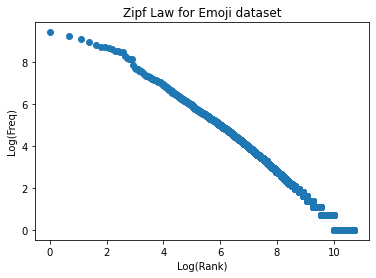

In [90]:
zipf_law(emoji, 'Emoji');

By simple visual inspection, the graph seems to be consistent with the empirical Zipf Law (a semi-straight line crosses the plot).

$$\frac{Type}{Token} ratio$$

Ratio of number of types (vocabulary size) to number of tokens
(text/corpus size).

In [91]:
len(token_counter(irony, n=len(irony_tokens))) / len(irony_tokens)

0.25513363553045504

## Emoji Data

### Number of Tweets

In [92]:
temp1 = pd.read_csv(EMOJI_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH+TRAIN_LABELS, names=['label'])
emoji_df = temp1.merge(temp2, left_index=True, right_index=True)  

emoji_val = token_data(EMOJI_RAW_PATH + VAL, EMOJI_INTERIM_PATH + VAL_INTERIM)

temp1 = pd.read_csv(EMOJI_INTERIM_PATH+VAL_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH+VAL_LABELS, names=['label'])
emoji_val_df = temp1.merge(temp2, left_index=True, right_index=True)

In [93]:
print(f"There are {emoji_df.shape[0]} Tweets in the Emoji data set.") #should be 45000
for i in range(20):
    print(f'{i}: ', (emoji_df[emoji_df['label'] == i].shape[0]))

There are 45000 Tweets in the Emoji data set.
0:  9204
1:  4901
2:  4713
3:  2043
4:  2146
5:  2132
6:  2078
7:  2345
8:  1287
9:  1391
10:  1982
11:  946
12:  1246
13:  980
14:  1224
15:  934
16:  1350
17:  1397
18:  1510
19:  1191


### Most Common Tokens

In [94]:
token_counter(emoji)

[('@user', 12209),
 ('the', 10346),
 ('!', 9045),
 ('to', 7645),
 ('I', 6535),
 ('a', 6100),
 ('my', 5965),
 ('in', 5688),
 ('and', 5389),
 ('with', 5049)]

### Least Common Tokens

In [95]:
token_counter(emoji, inverse=True)

[('Five50', 1),
 ('#happylaborday', 1),
 ('Nunez', 1),
 ('#bffweekend', 1),
 ('Players', 1),
 ('#rolltide', 1),
 ('#Alabama', 1),
 ('chefking1921express', 1),
 ('nector', 1),
 ('thedabberchick', 1)]

In [96]:
emoji_tokens = [t for l in emoji for t in l] # Get tokens for each line of the emoji data set
emoji_one_timers = []
emoji_mult_timers = []

for tup in token_counter(emoji, n=len(emoji_tokens)):
    k, v = tup # Unpack
    if v == 1:
        emoji_one_timers.append(k)
    else:
        emoji_mult_timers.append(k)

In [97]:
print(f'Number of words that occur only once:\
{len(emoji_one_timers)} ({len(emoji_one_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(emoji_mult_timers)} ({len(emoji_mult_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(emoji_tokens)}')

Number of words that occur only once:49420 (69%)
Number of words that occur more than once:21953 (31%)
Total word count, including repeated words: 511305


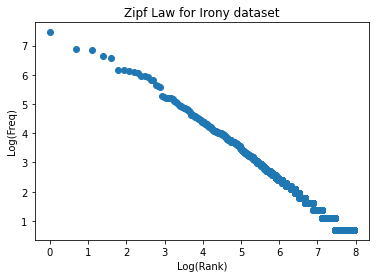

In [98]:
zipf_law(irony, 'Irony');

By simple visual inspection, the graph seems to be consistent with the empirical Zipf Law (a semi-straight line crosses the plot).

$$\frac{Type}{Token} ratio$$

Ratio of number of types (vocabulary size) to number of tokens
(text/corpus size).

In [99]:
len(token_counter(emoji, n=len(emoji_tokens))) / len(emoji_tokens)

0.1395898729721008

It seems the vocabulary on emoji tweets is narrower than the one on irony.

# Irony

## Maximum Likelihood

### Training the model

In [100]:
train, vocab = padded_everygram_pipeline(2, irony)
lm = MLE(2) # Maximum likelyhood estimator or order 2
len(lm.vocab) # Initializes an empty vocab

0

In [101]:
lm.fit(train, vocab) # which is filled with model data
len(lm.vocab)

10303

In [102]:
print(lm.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 10303 items>


In [103]:
lm.vocab.lookup(irony[0])
print(lm.counts)

<NgramCounter with 2 ngram orders and 89328 ngrams>


In [104]:
lm.score("<UNK>") == lm.score("aliens") # The token 'aliens' is not in our list

True

In [105]:
lm.score("a") # returns the relative frequency of 'a'

0.016422605488664713

In [106]:
lm.logscore("a") # This method avoids underflow

-5.92817315721575

In [107]:
lm.score('A')

0.000954550385074303

In [108]:
lm.score("@user") # most common word

0.03755287992190042

In [109]:
lm.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.14646464646464646

### Testing the Model

In [110]:
#load the validation set
irony_val = token_data(IRONY_RAW_PATH + VAL, IRONY_INTERIM_PATH+VAL_INTERIM)

In [111]:
lm.entropy(irony_val)

inf

In [112]:
lm.perplexity(irony_val)

inf

## Laplace

### Training the model

In [113]:
train, vocab = padded_everygram_pipeline(2, irony)
lm2 = Laplace(1)
len(lm2.vocab) # Initializes an empty vocab
lm2.fit(train, vocab) # which is filled with model data
len(lm2.vocab)

10303

In [114]:
print(lm2.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 10303 items>


In [115]:
lm2.score("<UNK>") == lm.score("aliens")

False

In [116]:
lm2.score("@user") # most common word

0.030710308876201284

In [117]:
lm2.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.0028568707742119798

### Testing the Model

In [118]:
lm2.entropy(irony_val)

13.333345004312507

In [119]:
lm2.perplexity(irony_val)

10321.356737145781

## KneserNeyInterpolated

### Training the model

In [120]:
train, vocab = padded_everygram_pipeline(2, irony)
lm3 = KneserNeyInterpolated(1)
print(len(lm3.vocab)) # Initializes an empty vocab
lm3.fit(train, vocab) # which is filled with model data
len(lm3.vocab)

0


10303

In [121]:
lm3.score("<UNK>") == lm.score("aliens")

False

In [122]:
lm3.score("@user") #most common word

9.705910899737941e-05

In [123]:
lm3.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.1459661646063665

### Testing the Model

In [124]:
lm3.entropy(irony_val)

13.802139172913105

In [125]:
lm3.perplexity(irony_val)

14284.264894756081

## WittenBellInterpolated

### Training the model

In [126]:
train, vocab = padded_everygram_pipeline(2, irony)
lm4 = WittenBellInterpolated(1)
print(len(lm4.vocab)) # Initializes an empty vocab
lm4.fit(train, vocab) # which is filled with model data
print(len(lm4.vocab))

0
10303


In [127]:
lm4.score("<UNK>") == lm.score("aliens")

True

In [128]:
lm4.score("@user") #most common word

0.03755287992190042

In [129]:
lm4.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.14606282864255174

### Testing the model

In [130]:
lm4.entropy(irony_val)

inf

In [131]:
lm4.perplexity(irony_val)

inf

## Bit of fun

In [132]:
ironic = irony_df[irony_df['label'] == 1]['tweet'].reset_index().drop('index', axis=1)
ironic_list = [t.split(',') for t in ironic['tweet']]

In [133]:
train, vocab = padded_everygram_pipeline(2, ironic_list)
lm_ironic = Laplace(1)
lm_ironic.fit(train, vocab)
lm_ironic.vocab;

In [134]:
#lm_ironic.generate(12, random_seed=4)

# Manual Annotation and Inter-Annotator Agreement: Task 3

In [135]:
rater_list = ['Dee', 'Sanna', 'Gino', 'August', 'Moneeca']

interrater_df = pd.read_csv('../datasets/iaa-sets/irony/iaa_labels.txt', names = ['True_label'])

for r in rater_list:
    raterX = pd.read_csv('../datasets/iaa-sets/irony/'+r+'Annotation.txt', names = [r])
    interrater_df = interrater_df.merge(raterX, left_index=True, right_index = True)

interrater_df.head()

,True_label,Dee,Sanna,Gino,August,Moneeca
0,1,1,1,1,1,1
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,1,1,1
4,1,1,0,0,1,1


In [136]:
print("Total Irony labels for true labels: ", str(interrater_df['True_label'].sum()).rjust(9))
for r in rater_list:
    print("Total Irony labels for "+r+" annotator: ", str(interrater_df[r].sum()).rjust(10-len(r)))

Total Irony labels for true labels:         55
Total Irony labels for Dee annotator:       44
Total Irony labels for Sanna annotator:     25
Total Irony labels for Gino annotator:      51
Total Irony labels for August annotator:    31
Total Irony labels for Moneeca annotator:   46


In [137]:
for i in rater_list: # We iterate through all the annotators
    x = interrater_df['True_label'][interrater_df['True_label'] == 1] # Transform labels to TRUE/FALSE
    y = interrater_df[i][interrater_df[i] == 1] # Transform labels to TRUE/FALSE
    ratio = sum(np.bitwise_and(x, y)) / len(x) # Sum all coincidences and divide by the length
    print("Coincidence ratio for "+i+ "{:.1%}".format(ratio).rjust(15-len(i)))

Coincidence ratio for Dee       63.6%
Coincidence ratio for Sanna     38.2%
Coincidence ratio for Gino      60.0%
Coincidence ratio for August    50.9%
Coincidence ratio for Moneeca   60.0%


In [138]:
interrater_df['agree'] =  ((interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                            interrater_df['August'] + interrater_df['Moneeca']) == 0) |\
                            (interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                            interrater_df['August'] + interrater_df['Moneeca'] == 5)

agreed = interrater_df['agree'].sum()
a_0 = agreed/len(interrater_df)
print(f"All annotators agreed in {agreed} number of observations ({(a_0):.1%})")

All annotators agreed in 48 number of observations (40.0%)


In [139]:
# adjust for chance, assumption that there is a uniform distribution where p = 0.5 to choose 0 or 1.
p = 0.5
a_c = (p)**len(rater_list)
a_adj = (a_0 - a_c)/(1-a_c)

print(f'{a_adj:.1%}')

38.1%


Let's explore our interagreement annotations to find our limitations.

In [140]:
interrater_df[interrater_df['agree'] == False]

,True_label,Dee,Sanna,Gino,August,Moneeca,agree
3,0,0,0,1,1,1,False
4,1,1,0,0,1,1,False
5,1,1,0,0,1,0,False
7,1,1,1,0,0,1,False
8,1,1,1,1,1,0,False
...,...,...,...,...,...,...,...
115,0,0,0,0,0,1,False
116,0,1,1,0,0,0,False
117,1,0,1,0,0,0,False
118,1,1,0,0,0,0,False


### Phenomena that caused the biggest problems for inter-annotator agreement

* Lack of context to give understanding of the text. For example, some seem to reference a photo
* Some texts refer to specific pop culture or niche subject matter that was not understood or known by the annotators. For example, reference to sports, people, or twitter related subject matter.
* Perspective biases of the annotators based on gender, culture, personal background, previous experience or work.
* Emojis in the text do not clarify the understanding of the text itself.
* Poor grammer/ sentense structure/ spelling, etc making it difficult to understand the text. **Schizophrenic twits**.

In addition, we noticed inconsistencies with our own annotation choices (intra-annotations).


# Classifying and Predicting with Validation Data

## Irony Classification and Prediction

### Using SGDClassifier

In [143]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), analyzer = 'word',tokenizer=tokenise)), #vectorises
                     ('tfidf', TfidfTransformer()), #reduces common word weighting
                     ('clf', SGDClassifier(loss='log',shuffle=False))]) #classifier 

bob = text_clf.fit(irony_df['tweet'], irony_df['label'])

bob_predicted = bob.predict(irony_val_df['tweet'])
np.mean(bob_predicted == irony_val_df['label'])

0.6450261780104712

In [145]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', SGDClassifier())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False), # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__alpha': (1e-4, 1e-7),
              'clf__loss': ('log','hinge'),
              'clf__shuffle': (False, False) # shuffle = False removes the random element for reproducibility 
}

# GridSearch Classifier
sgd_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
sgd_clf = sgd_clf.fit(irony_df['tweet'], irony_df['label'])

# Print GridSearchCV Best Score
print(sgd_clf.best_score_)

# Print Parameters that were the best
for i in sgd_clf.best_params_: print(i,sgd_clf.best_params_[i])

# Predict Based on Classifier
sgd_predicted = sgd_clf.predict(irony_val_df['tweet'])
np.mean(sgd_predicted == irony_val_df['label'])

0.6327682788415773
clf__loss log
clf__shuffle False
vect__ngram_range (1, 1)
vect__tokenizer <function tokenise at 0x000001AF6452CC10>


0.6376963350785341

### Using MultinomialNB

In [146]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', MultinomialNB())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False), # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              'tfidf__use_idf': (True, False), # default = True
              'clf__alpha': (1.0, 2.0) # default = 1.0
}

# GridSearch Classifier
mnb_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
mnb_clf = mnb_clf.fit(irony_df['tweet'], irony_df['label'])

# Print GridSearchCV Best Score
print(mnb_clf.best_score_)

# Print Parameters that were the best
for i in mnb_clf.best_params_: print(i,mnb_clf.best_params_[i])

# Predict Based on Classifier
mnb_predicted = mnb_clf.predict(irony_val_df['tweet'])
np.mean(mnb_predicted == irony_val_df['label'])

0.6230006468226363
clf__alpha 2.0
tfidf__use_idf False
vect__ngram_range (1, 2)
vect__tokenizer None


0.631413612565445

### Using RandomForestClassifier

In [147]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', RandomForestClassifier())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              'tfidf__use_idf': (True, False), # default = True
              #'clf__max_depth': (5,None,), # default = None
              'clf__random_state': (0,None) # default = None
}

# GridSearch Classifier
rfc_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
rfc_clf = rfc_clf.fit(irony_df['tweet'], irony_df['label'])

# Print GridSearchCV Best Score
print(rfc_clf.best_score_)

# Print Parameters that were the best
for i in rfc_clf.best_params_: print(i,rfc_clf.best_params_[i])

# Predict Based on Classifier
rfc_predicted = rfc_clf.predict(irony_val_df['tweet'])
np.mean(rfc_predicted == irony_val_df['label'])

0.6285865094765619
clf__random_state 0
tfidf__use_idf False
vect__ngram_range (1, 1)
vect__tokenizer <function tokenise at 0x000001AF6452CC10>


0.6335078534031413

### Classification Report / Confusion Matrices

In [148]:
print(classification_report(irony_val_df['label'], sgd_predicted))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       499
           1       0.62      0.64      0.63       456

    accuracy                           0.64       955
   macro avg       0.64      0.64      0.64       955
weighted avg       0.64      0.64      0.64       955



In [149]:
print(f'Overall Model Accuracy: {accuracy_score(irony_val_df["label"], sgd_predicted):.2%}')

Overall Model Accuracy: 63.77%


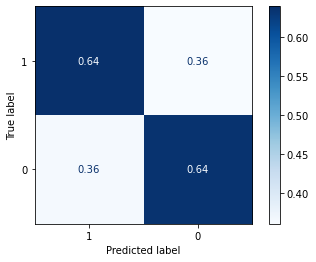

In [150]:
# Plot the confusion matrix for the SGD classifier model
plot_confusion_matrix(sgd_clf, irony_val_df['tweet'], irony_val_df['label'],
                                 display_labels=[1, 0],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

#plt.savefig('./reports/figures/SGD-Irony-confusion-matrix-validation.png')
plt.show();

## Emoji Classifying and Predicting

### Using SGDClassifier

In [151]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', SGDClassifier())]) # classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__alpha': (1e-4, 1e-7), # default 1e-4
              #'clf__loss': ('log','hinge'), # default = 'hinge'
              'clf__shuffle': (True, False) # shuffle = False removes the random element for reproducibility 
}

# GridSearch Classifier
emoji_sgd_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
emoji_sgd_clf = emoji_sgd_clf.fit(emoji_df['tweet'], emoji_df['label'])

# Print GridSearchCV Best Score
print(emoji_sgd_clf.best_score_)

# Print Parameters that were the best
for i in emoji_sgd_clf.best_params_: print(i,emoji_sgd_clf.best_params_[i])

# Predict Based on Classifier
emoji_sgd_predicted = emoji_sgd_clf.predict(emoji_val_df['tweet'])
np.mean(emoji_sgd_predicted == emoji_val_df['label'])

0.2959777777777778
clf__shuffle True
vect__ngram_range (1, 2)
vect__tokenizer <function tokenise at 0x000001AF6452CC10>


0.3146

### Using MultinomialNB

In [152]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', MultinomialNB())]) #classifies

# Parameters to test for best performance
parameters = {#'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None), # default = None
              #'tfidf__use_idf': (True, False), # defaultl = True
              #'clf__alpha': (1.0, 2.0)
}

# GridSearch Classifier
emoji_mnb_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
emoji_mnb_clf = emoji_mnb_clf.fit(emoji_df['tweet'], emoji_df['label'])

# Print GridSearchCV Best Score
print(emoji_mnb_clf.best_score_)

# Print Parameters that were the best
for i in emoji_mnb_clf.best_params_: print(i,emoji_mnb_clf.best_params_[i])

# Predict Based on Classifier
emoji_mnb_predicted = emoji_mnb_clf.predict(emoji_val_df['tweet'])
np.mean(emoji_mnb_predicted == emoji_val_df['label'])

0.22164444444444445
vect__tokenizer None


0.232

### Using RandomForestClassifier

Using RandomForestClassifier uses a huge amount of time, even when limiting the parameter options. The best rating was was less than the accuracy of the SGD Classifier.

In [153]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', RandomForestClassifier())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__max_depth': (5,None,), # default = None
              #'clf__random_state': (0,None) # default = None
}

# GridSearch Classifier
#emoji_rfc_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
#emoji_rfc_clf = emoji_rfc_clf.fit(emoji_df['tweet'], emoji_df['label'])

# Print GridSearchCV Best Score
#print(emoji_rfc_clf.best_score_)

# Print Parameters that were the best
#for i in emoji_rfc_clf.best_params_: print(i,emoji_rfc_clf.best_params_[i])

# Predict Based on Classifier
#emoji_rfc_predicted = emoji_rfc_clf.predict(emoji_val_df['tweet'])
#np.mean(emoji_rfc_predicted == emoji_val_df['label'])

In [155]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), analyzer = 'word',tokenizer=tokenise)), #vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', RandomForestClassifier())]) #classifier 

emoji_rfc = text_clf.fit(emoji_df['tweet'], emoji_df['label'])

emoji_rfc_predicted = emoji_rfc.predict(emoji_val_df['tweet'])
np.mean(emoji_rfc_predicted == emoji_val_df['label'])

KeyboardInterrupt: 

### Classification Report / Confusion Matrices

In [156]:
print(classification_report(emoji_val_df['label'], emoji_sgd_predicted))

              precision    recall  f1-score   support

           0       0.34      0.56      0.43      1056
           1       0.25      0.26      0.26       521
           2       0.35      0.56      0.43       504
           3       0.22      0.08      0.12       308
           4       0.37      0.47      0.42       243
           5       0.20      0.11      0.14       238
           6       0.17      0.10      0.12       204
           7       0.28      0.24      0.26       199
           8       0.33      0.10      0.16       177
           9       0.25      0.09      0.13       171
          10       0.25      0.30      0.27       159
          11       0.59      0.31      0.41       143
          12       0.29      0.27      0.28       129
          13       0.34      0.08      0.13       153
          14       0.15      0.08      0.10       129
          15       0.22      0.08      0.12       148
          16       0.13      0.05      0.07       137
          17       0.47    

In [158]:
print(f'Overall Model Accuracy: {accuracy_score(emoji_val_df["label"], emoji_sgd_predicted):.2%}')

Overall Model Accuracy: 31.46%


In [163]:
emoji_val_df['label'].unique()

array([ 0,  7, 11,  2,  1,  8, 13,  9, 16, 19,  4,  6, 14,  5, 10, 15,  3,
       12, 17, 18], dtype=int64)

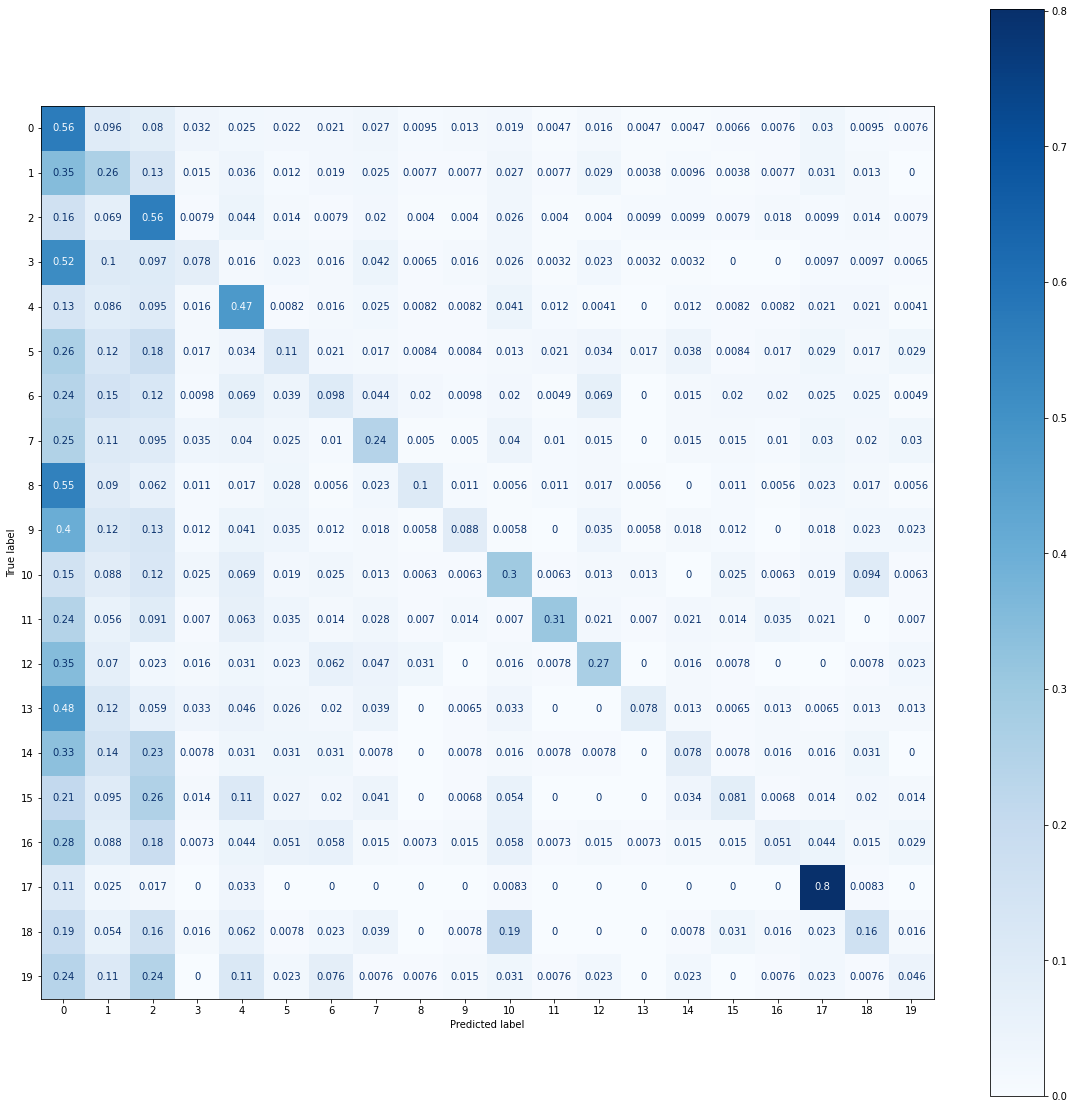

In [167]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots(figsize=(20,20))

plot_confusion_matrix(emoji_sgd_clf, emoji_val_df['tweet'], emoji_val_df['label'],
                                 display_labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

#plt.savefig('./reports/figures/SGD-Emoji-confusion-matrix-validation.png')
plt.show();